In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import pandas as pd
from matplotlib import font_manager

In [98]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [99]:
import os
import sys

notebook_dir = os.getcwd() 
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)

from utils import TranslationDataset  
from tokenizers import Tokenizer
from model import build_transformer


In [100]:
def get_hindi_font():
    for font in font_manager.findSystemFonts(fontpaths=None, fontext='ttf'):
        if any(name in font for name in ['NotoSansDevanagari', 'Mangal', 'Lohit-Devanagari', 'Nirmala']):
            return font
    return None

hindi_font_path = get_hindi_font()
plt.rcParams['font.family'] = font_manager.FontProperties(fname=hindi_font_path).get_name()

def plot_attention(src_tokens, tgt_tokens, attention, layer=0, head=0):
    attention = attention[:len(tgt_tokens), :len(src_tokens)]
    src_tokens = [str(t) for t in src_tokens[:attention.shape[1]]]
    tgt_tokens = [str(t) for t in tgt_tokens[:attention.shape[0]]]

    plt.figure(figsize=(12, 6))
    sns.heatmap(attention, xticklabels=src_tokens, yticklabels=tgt_tokens, cmap='viridis')
    plt.xlabel("Source Tokens", fontsize=12)
    plt.ylabel("Target Tokens", fontsize=12)
    plt.title(f"Attention - Layer {layer}, Head {head}", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


In [101]:
val_df = pd.read_csv("/home/careinfolab/Dr_Luo/Rohan/Linear_Attention/Dataset/validation.csv")
en_tokenizer = Tokenizer.from_file("/home/careinfolab/Dr_Luo/Rohan/Linear_Attention/Notebook/custom_en_tokenizer.json")
hi_tokenizer = Tokenizer.from_file("/home/careinfolab/Dr_Luo/Rohan/Linear_Attention/Notebook/custom_hi_tokenizer.json")

val_dataset = TranslationDataset(
    df=val_df,
    tokenizer_src=en_tokenizer,
    tokenizer_tgt=hi_tokenizer,
    src_lang="english_sentence",
    tgt_lang="hindi_sentence",
    seq_len=128
)

from torch.utils.data import DataLoader
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)


🔄 Preprocessing and tokenizing dataset...


Tokenizing: 100%|██████████| 35529/35529 [00:03<00:00, 8919.24it/s]

✅ Loaded 35529 valid examples.


In [102]:
val_df = pd.read_csv("/home/careinfolab/Dr_Luo/Rohan/Linear_Attention/Dataset/validation.csv")
en_tokenizer = Tokenizer.from_file("/home/careinfolab/Dr_Luo/Rohan/Linear_Attention/Notebook/custom_en_tokenizer.json")
hi_tokenizer = Tokenizer.from_file("/home/careinfolab/Dr_Luo/Rohan/Linear_Attention/Notebook/custom_hi_tokenizer.json")

val_dataset = TranslationDataset(
    df=val_df,
    tokenizer_src=en_tokenizer,
    tokenizer_tgt=hi_tokenizer,
    src_lang="english_sentence",
    tgt_lang="hindi_sentence",
    seq_len=128
)

from torch.utils.data import DataLoader
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2, pin_memory=True)


🔄 Preprocessing and tokenizing dataset...


Tokenizing: 100%|██████████| 35529/35529 [00:04<00:00, 8447.55it/s]

✅ Loaded 35529 valid examples.


In [110]:
model = build_transformer(
    src_vocab_size=en_tokenizer.get_vocab_size(),
    tgt_vocab_size=hi_tokenizer.get_vocab_size(),
    src_seq_len=128,
    tgt_seq_len=128,
    d_model=256, 
    N=4,
    h=4,
    dropout=0.3,
    d_ff=1024,
    use_Linear=False
)


In [111]:
checkpoint = torch.load("/home/careinfolab/Dr_Luo/Rohan/Linear_Attention/results/Vanilla_Transformer/checkpoints/best_model.pth", map_location='cuda')

model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in checkpoint.items() if k in model_dict and v.shape == model_dict[k].shape}
model_dict.update(pretrained_dict)

model.load_state_dict(model_dict)
model.to(device)
model.eval()


/tmp/ipykernel_1374827/3748941361.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/home/careinfolab/Dr_Luo/Rohan/Linear_Attention/results/Vanill

Transformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-3): 4 x EncoderBlock(
        (self_attn): MultiHeadAttentionBlock(
          (w_q): Linear(in_features=256, out_features=256, bias=False)
          (w_k): Linear(in_features=256, out_features=256, bias=False)
          (w_v): Linear(in_features=256, out_features=256, bias=False)
          (w_o): Linear(in_features=256, out_features=256, bias=False)
          (dropout): Dropout(p=0.3, inplace=False)
        )
        (ff): FeedForwardBlock(
          (linear_1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
          (linear_2): Linear(in_features=1024, out_features=256, bias=True)
        )
        (res_conns): ModuleList(
          (0-1): 2 x ResidualConnection(
            (dropout): Dropout(p=0.3, inplace=False)
            (norm): LayerNormalization()
          )
        )
      )
    )
    (norm): LayerNormalization()
  )
  (decoder): Decoder(
    (laye

In [112]:
count = 0
with torch.no_grad():
    for batch in val_loader:
        encoder_input = batch["encoder_input"].to(device)
        encoder_mask = batch["encoder_mask"].to(device)
        decoder_input = batch["decoder_input"].to(device)
        decoder_mask = batch["decoder_mask"].to(device)

        src_text = batch["src_text"][0]
        tgt_text = batch["tgt_text"][0]

        encoder_output = model.encode(encoder_input, encoder_mask)

        decoder_output, attention_weights = model.decode(
            encoder_output, encoder_mask,
            decoder_input, decoder_mask,
            return_attention=True
        )

        src_tokens = src_text.split()
        tgt_tokens = tgt_text.split()
        count += 1
        if count == 3:
            break


In [113]:
valid_attn = [a for a in attention_weights if a is not None]
if not valid_attn:
    raise ValueError("No attention weights available to plot.")
attn_matrix = torch.stack(valid_attn).squeeze(1).detach().cpu().numpy() 


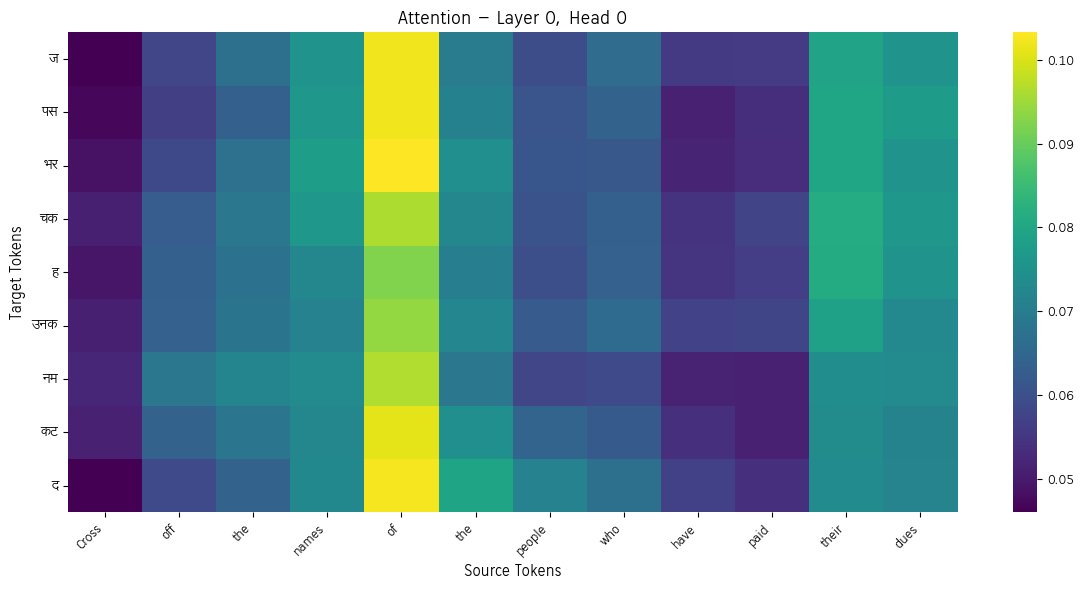

In [114]:
layer = 0
head = 0
attn = attn_matrix[layer][head]
src_tokens = [str(token) for token in src_tokens[:attn.shape[-1]]]
tgt_tokens = [str(token) for token in tgt_tokens[:attn.shape[-2]]]

plot_attention(src_tokens, tgt_tokens, attn, layer=layer, head=head)


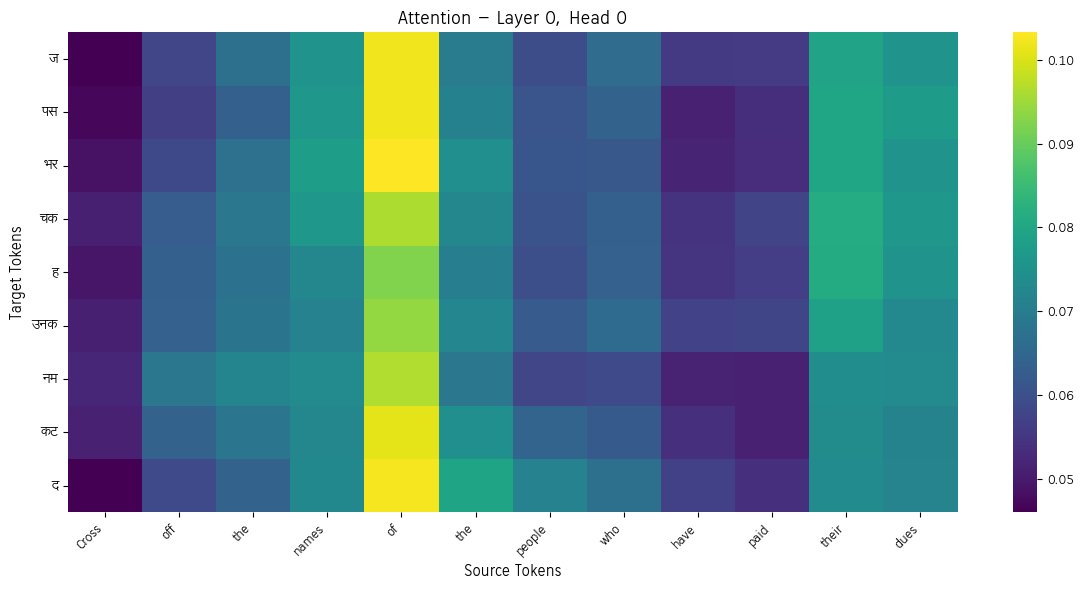

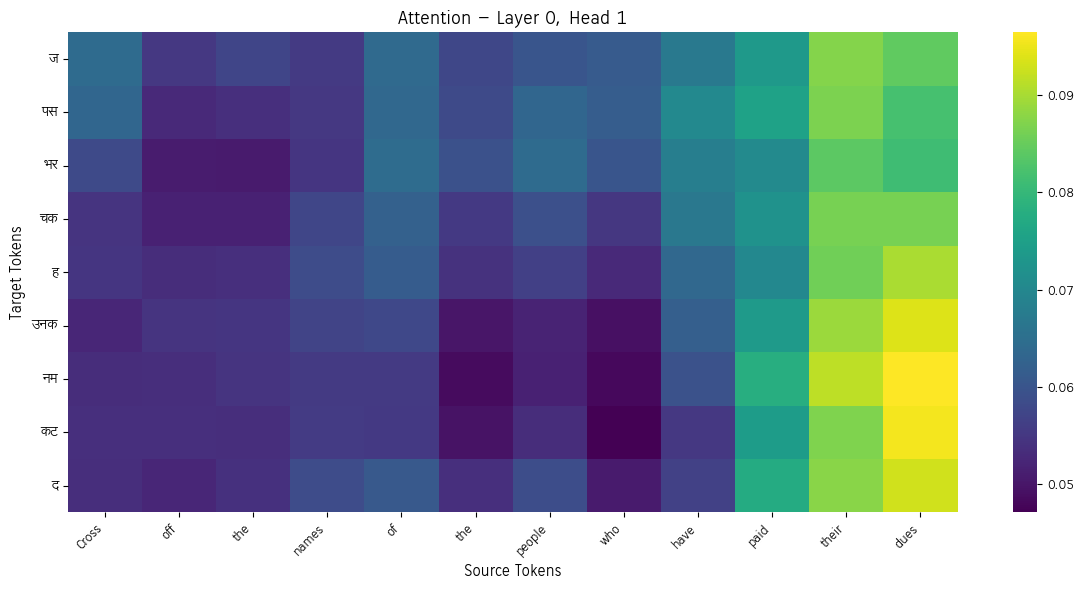

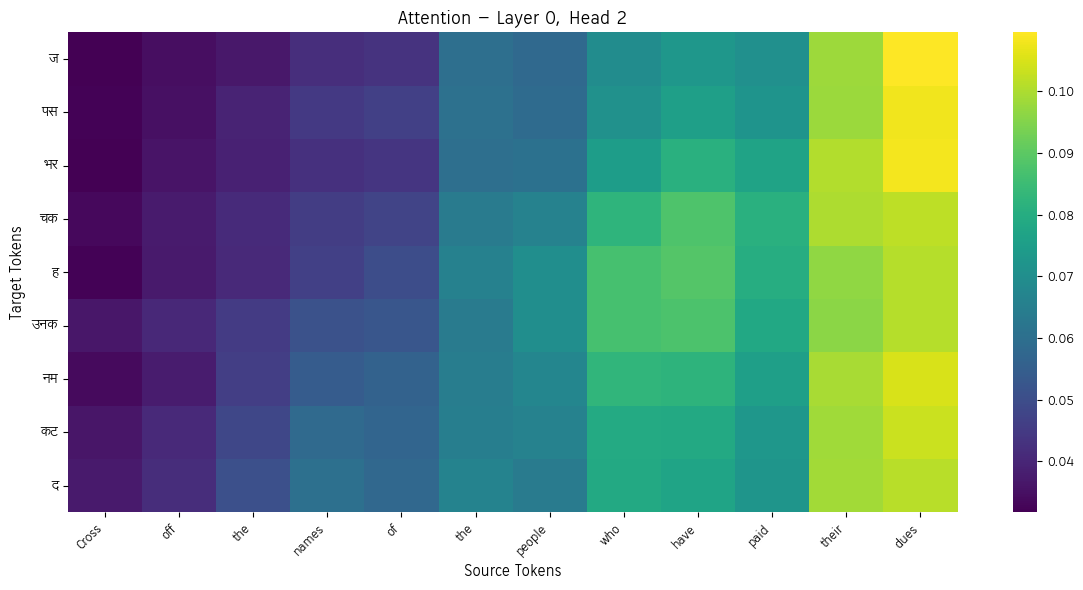

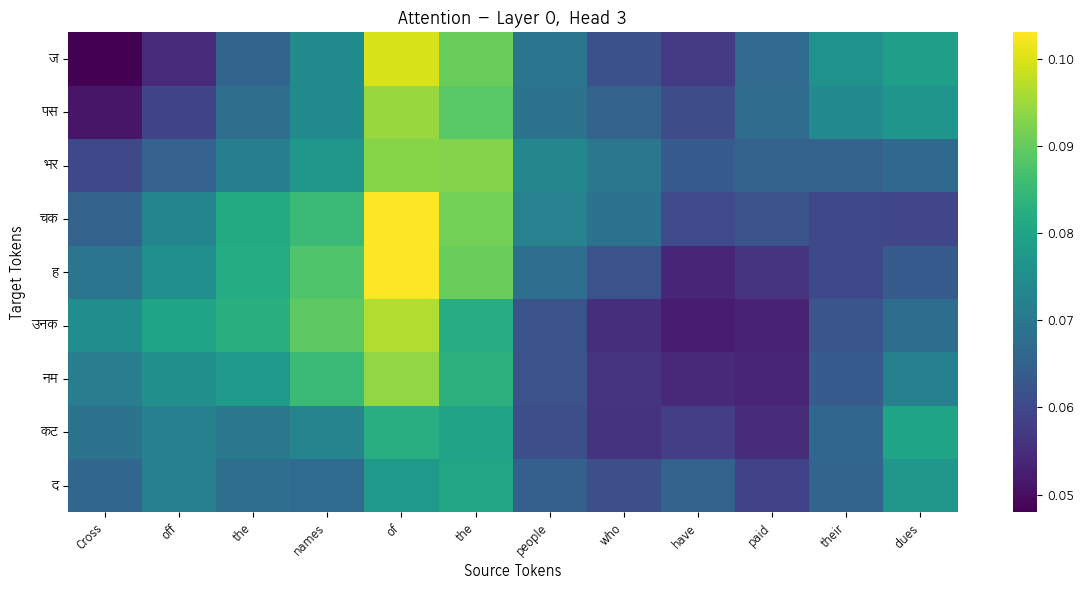

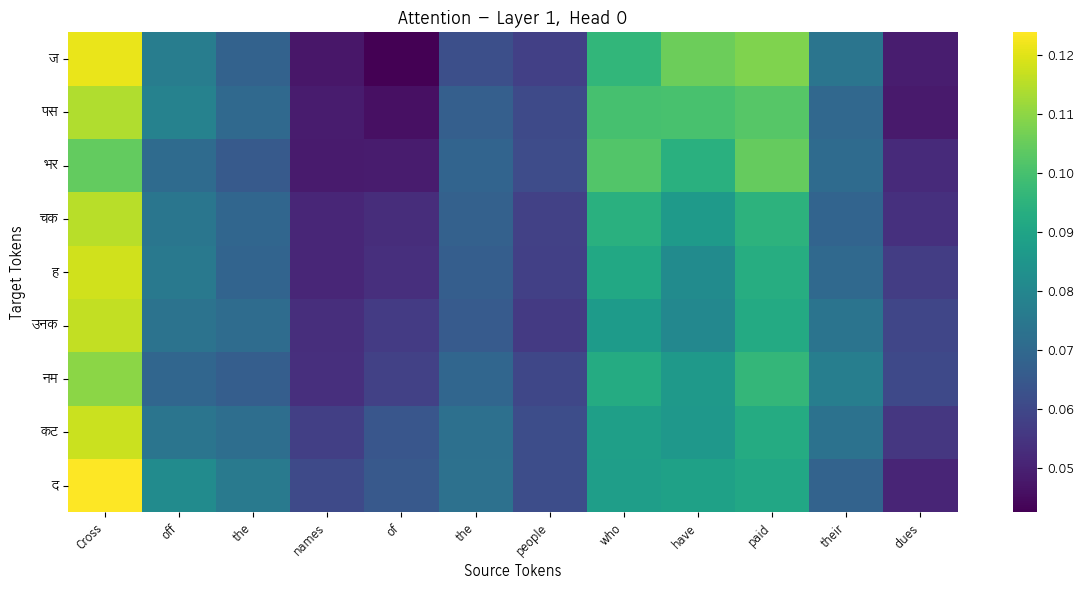

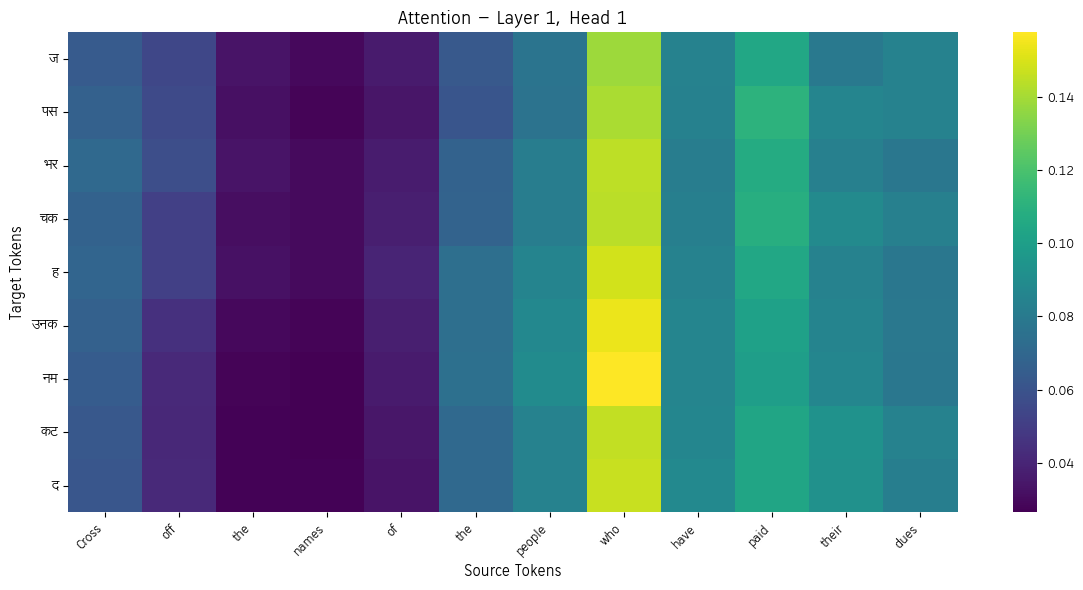

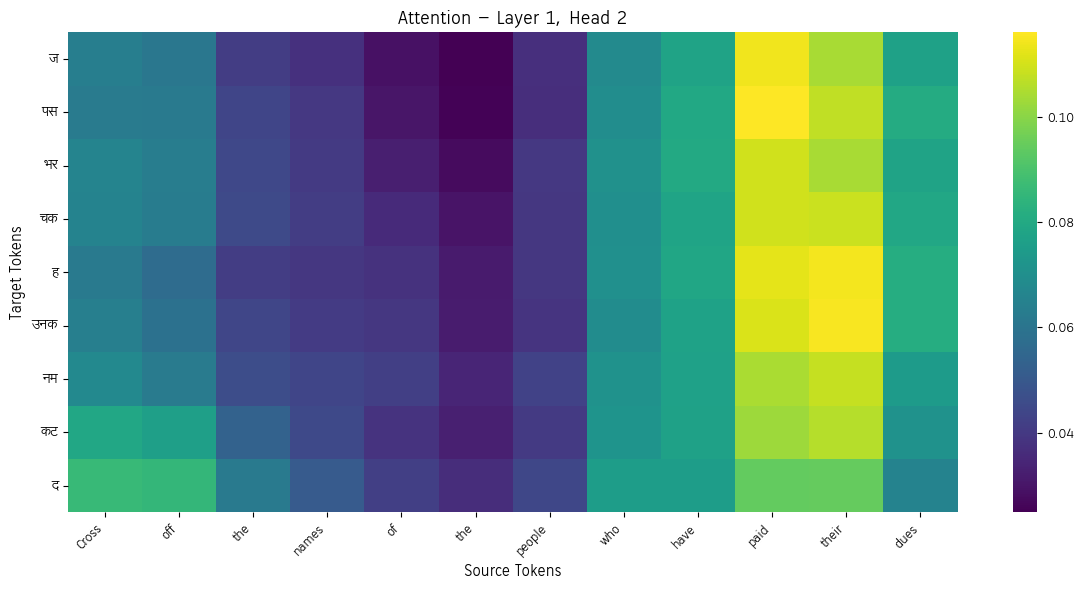

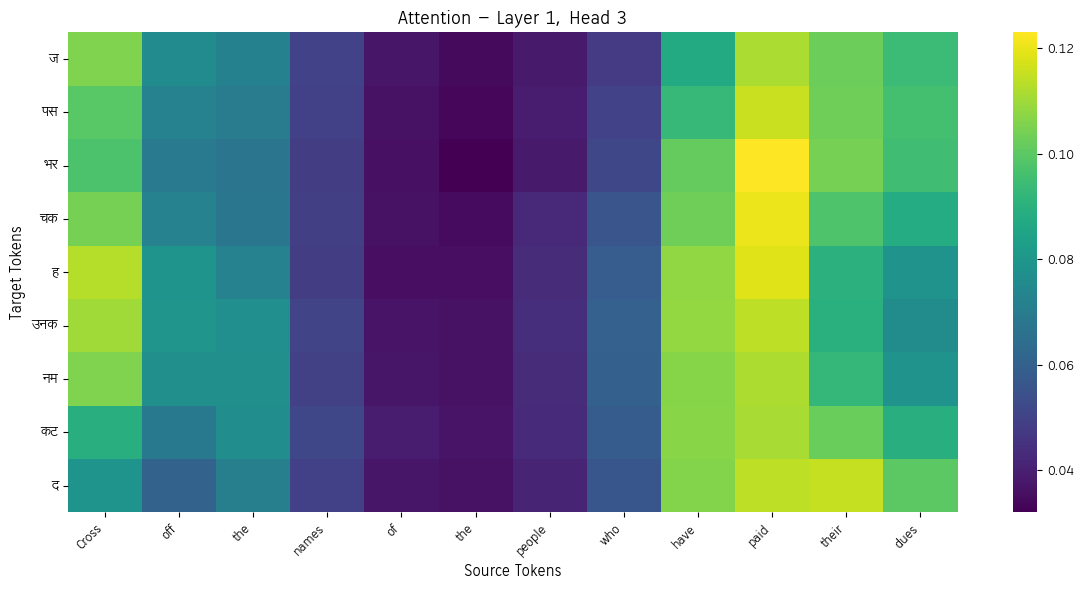

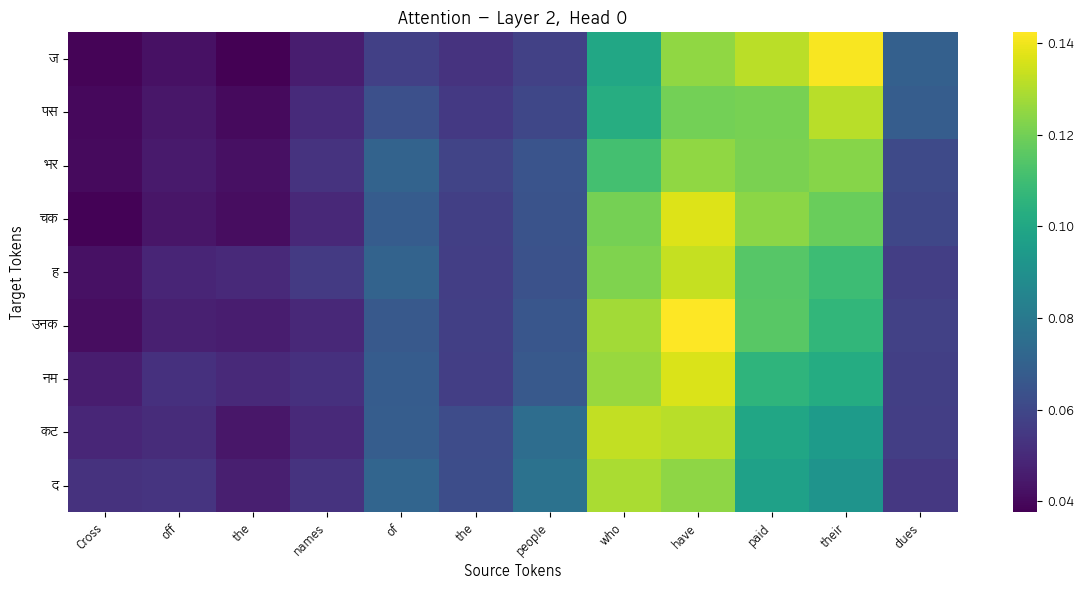

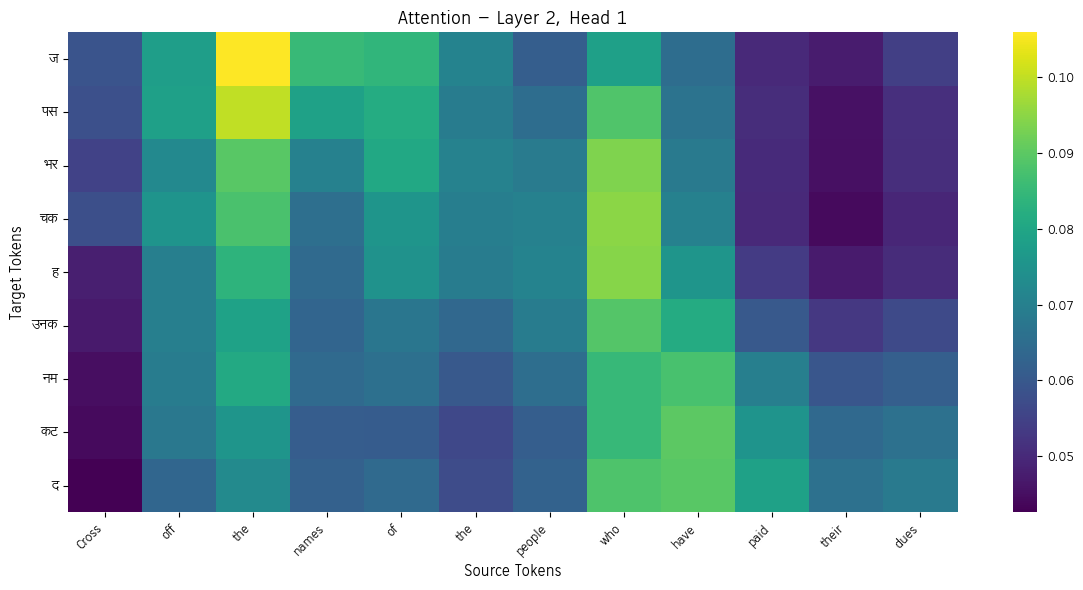

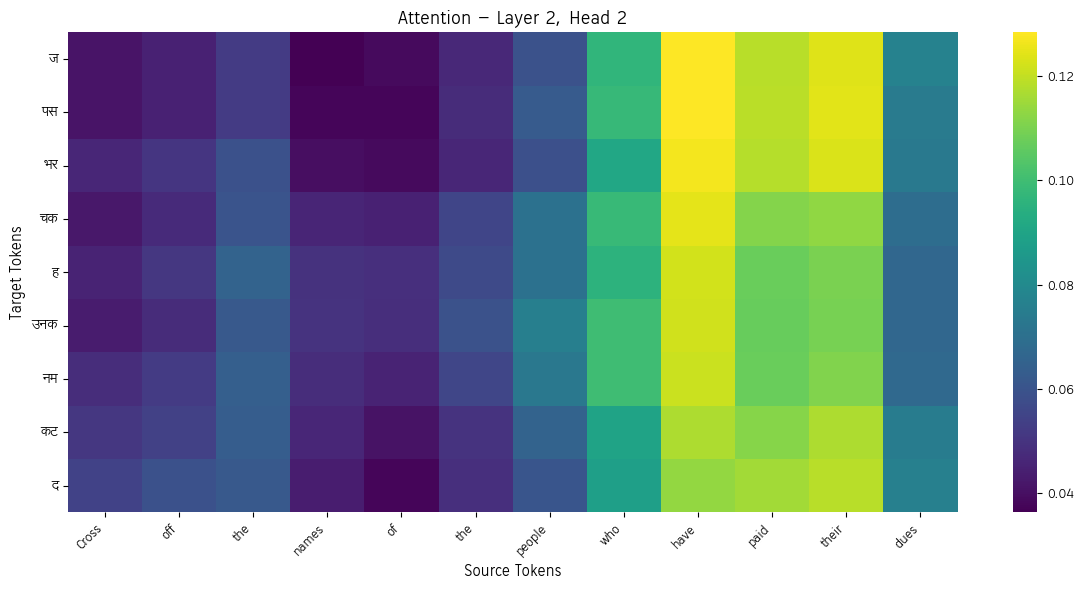

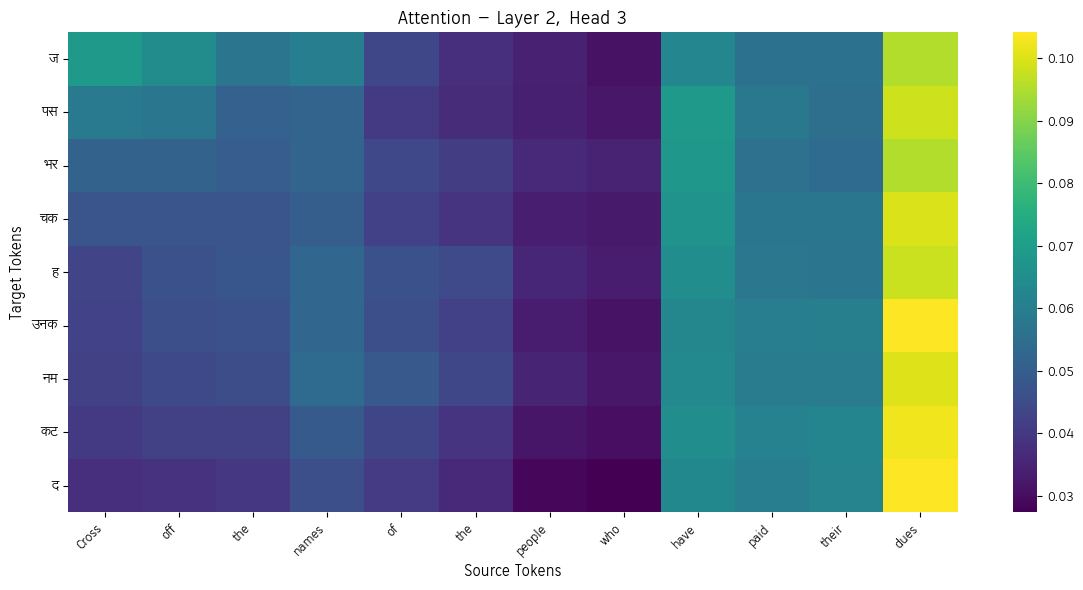

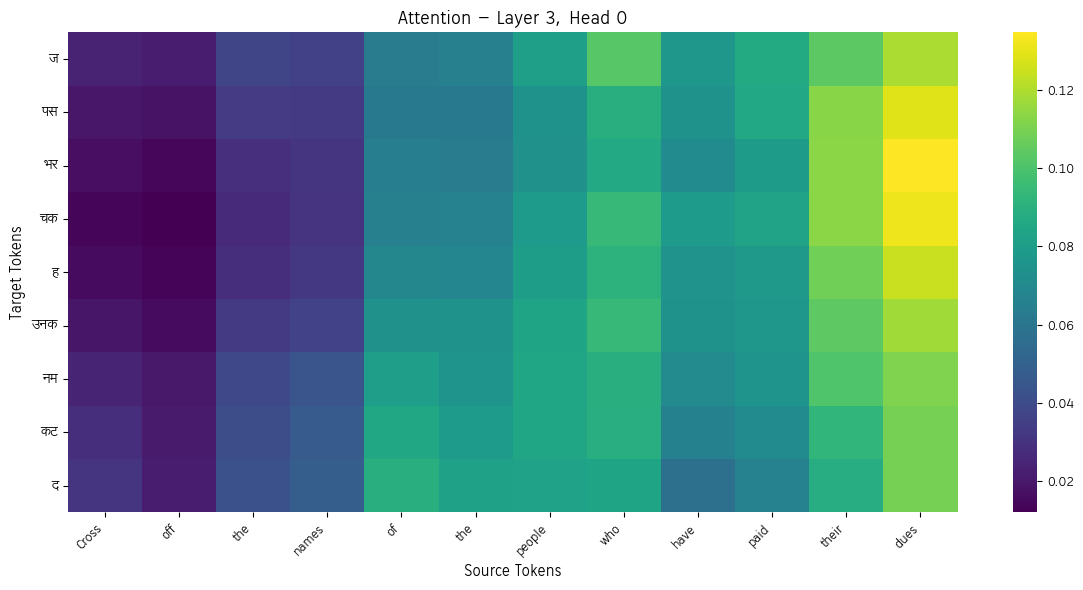

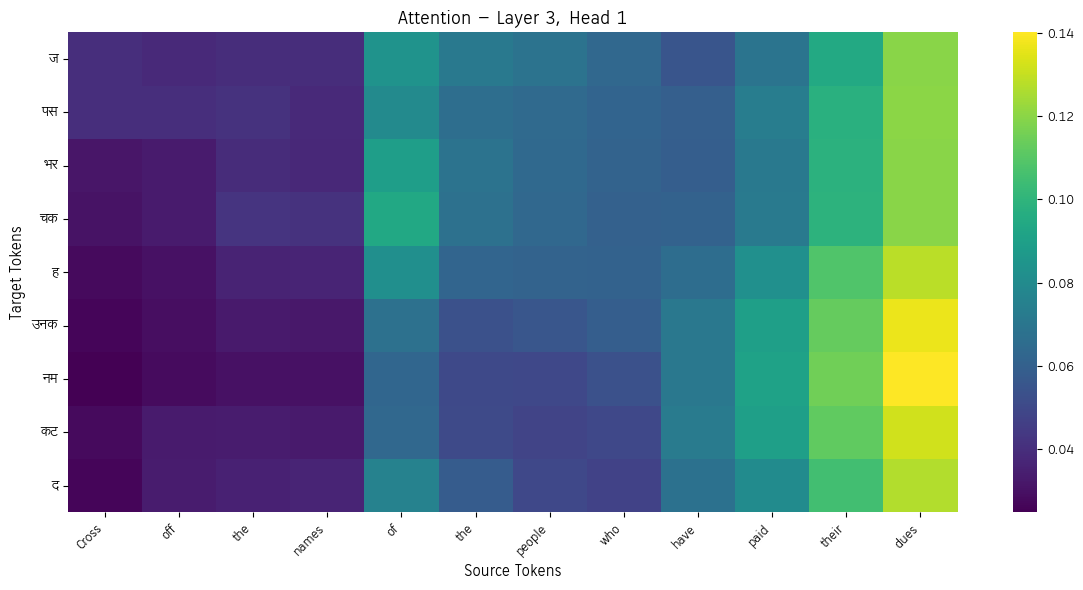

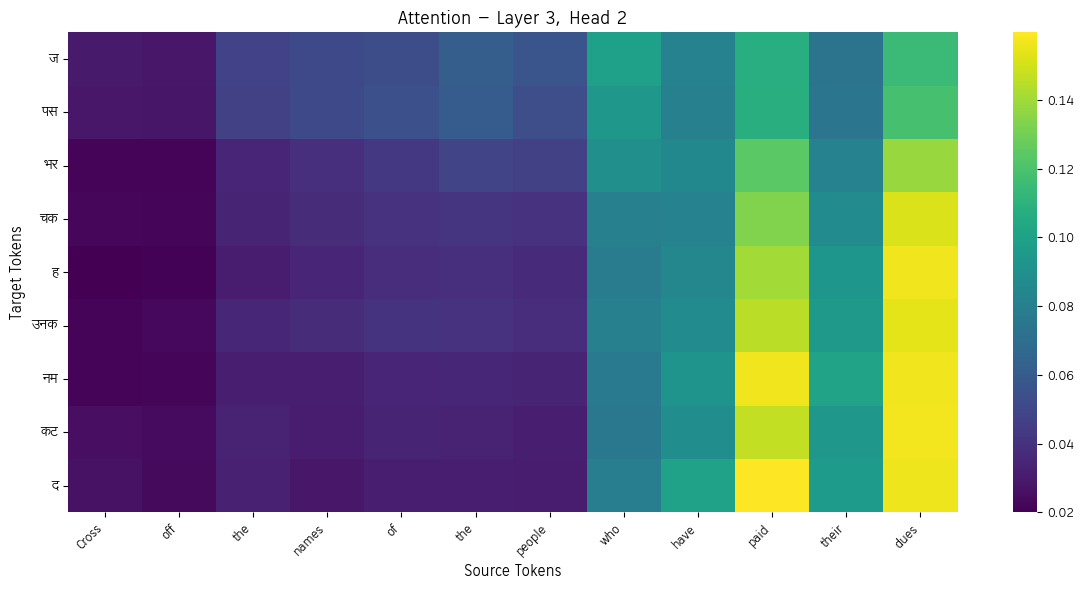

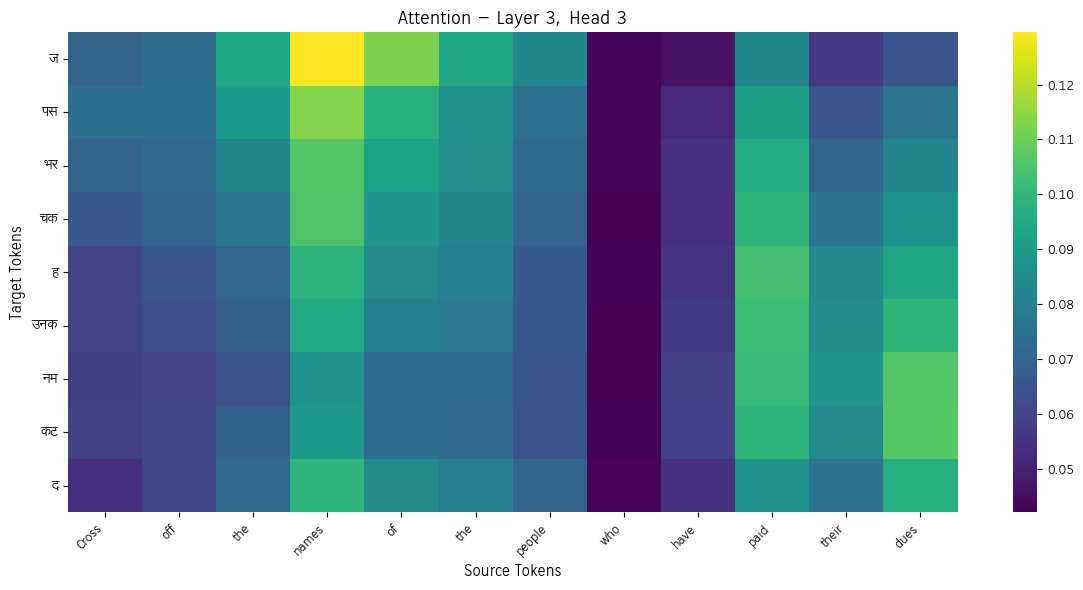

In [115]:
num_layers = attn_matrix.shape[0]
num_heads = attn_matrix.shape[1]

for l in range(num_layers):
    for h in range(num_heads):
        attn = attn_matrix[l][h]
        plot_attention(src_tokens, tgt_tokens, attn, layer=l, head=h)


# Linear Attention

In [109]:
Linear_model = build_transformer(
    src_vocab_size=en_tokenizer.get_vocab_size(),
    tgt_vocab_size=hi_tokenizer.get_vocab_size(),
    src_seq_len=128,
    tgt_seq_len=128,
    d_model=256,
    N=4,
    h=4,
    dropout=0.3,
    d_ff=1024,
    use_Linear=True  # <- using linear attention
)


In [90]:
checkpoint = torch.load(
    "/home/careinfolab/Dr_Luo/Rohan/Linear_Attention/results/Linear_Transformer1/checkpoints/best_model.pth",
    map_location='cuda'
)

model_dict = Linear_model.state_dict()
pretrained_dict = {k: v for k, v in checkpoint.items() if k in model_dict and v.shape == model_dict[k].shape}
model_dict.update(pretrained_dict)

Linear_model.load_state_dict(model_dict)
Linear_model.to(device)
Linear_model.eval()


/tmp/ipykernel_1374827/1707568065.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(


Transformer(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-3): 4 x EncoderBlock(
        (self_attn): MultiHeadAttentionBlock(
          (w_q): Linear(in_features=256, out_features=256, bias=False)
          (w_k): Linear(in_features=256, out_features=256, bias=False)
          (w_v): Linear(in_features=256, out_features=256, bias=False)
          (w_o): Linear(in_features=256, out_features=256, bias=False)
          (dropout): Dropout(p=0.3, inplace=False)
        )
        (ff): FeedForwardBlock(
          (linear_1): Linear(in_features=256, out_features=1024, bias=True)
          (dropout): Dropout(p=0.3, inplace=False)
          (linear_2): Linear(in_features=1024, out_features=256, bias=True)
        )
        (res_conns): ModuleList(
          (0-1): 2 x ResidualConnection(
            (dropout): Dropout(p=0.3, inplace=False)
            (norm): LayerNormalization()
          )
        )
      )
    )
    (norm): LayerNormalization()
  )
  (decoder): Decoder(
    (laye

In [93]:
count = 0
with torch.no_grad():
    for batch in val_loader:
        encoder_input = batch["encoder_input"].to(device)
        encoder_mask = batch["encoder_mask"].to(device)
        decoder_input = batch["decoder_input"].to(device)
        decoder_mask = batch["decoder_mask"].to(device)

        src_text = batch["src_text"][0]
        tgt_text = batch["tgt_text"][0]

        encoder_output = model.encode(encoder_input, encoder_mask)

        decoder_output, attention_weights = model.decode(
            encoder_output, encoder_mask,
            decoder_input, decoder_mask,
            return_attention=True
        )

        src_tokens = src_text.split()
        tgt_tokens = tgt_text.split()
        count += 1
        if count == 3:
            break


In [94]:
valid_attn = [a for a in attention_weights if a is not None]
if not valid_attn:
    raise ValueError("No attention weights available to plot.")
attn_matrix = torch.stack(valid_attn).squeeze(1).detach().cpu().numpy() 

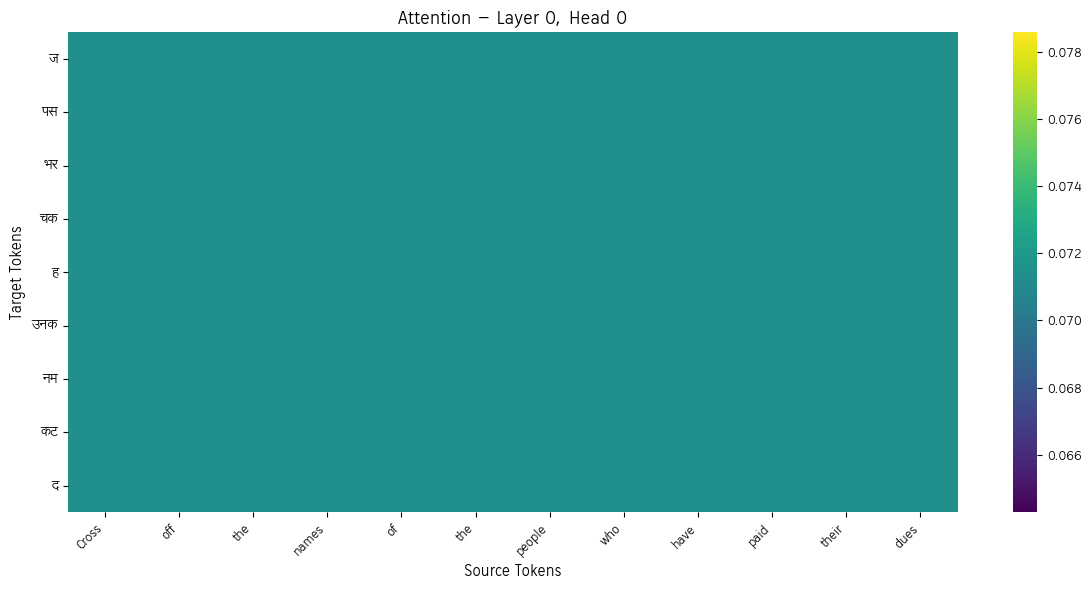

In [95]:
layer = 0
head = 0
attn = attn_matrix[layer][head]
src_tokens = [str(token) for token in src_tokens[:attn.shape[-1]]]
tgt_tokens = [str(token) for token in tgt_tokens[:attn.shape[-2]]]

plot_attention(src_tokens, tgt_tokens, attn, layer=layer, head=head)


In [87]:
with torch.no_grad():
    for batch in val_loader:
        encoder_input = batch["encoder_input"].to(device)
        encoder_mask = batch["encoder_mask"].to(device)

        src_text = batch["src_text"][0]
        src_tokens = src_text.split()

        _ = Linear_model.encode(encoder_input, encoder_mask)
        break


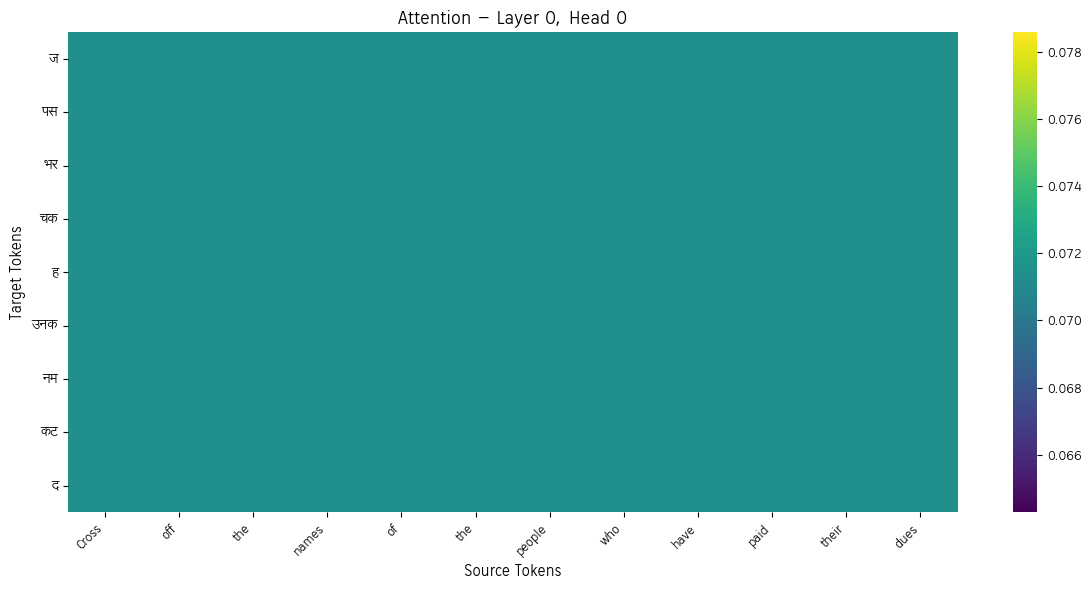

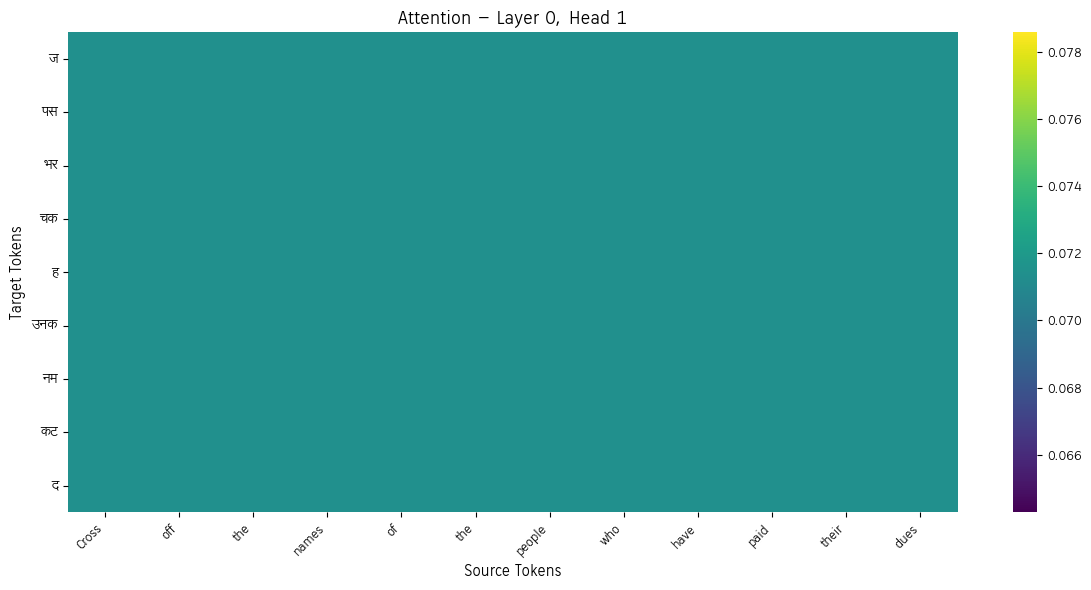

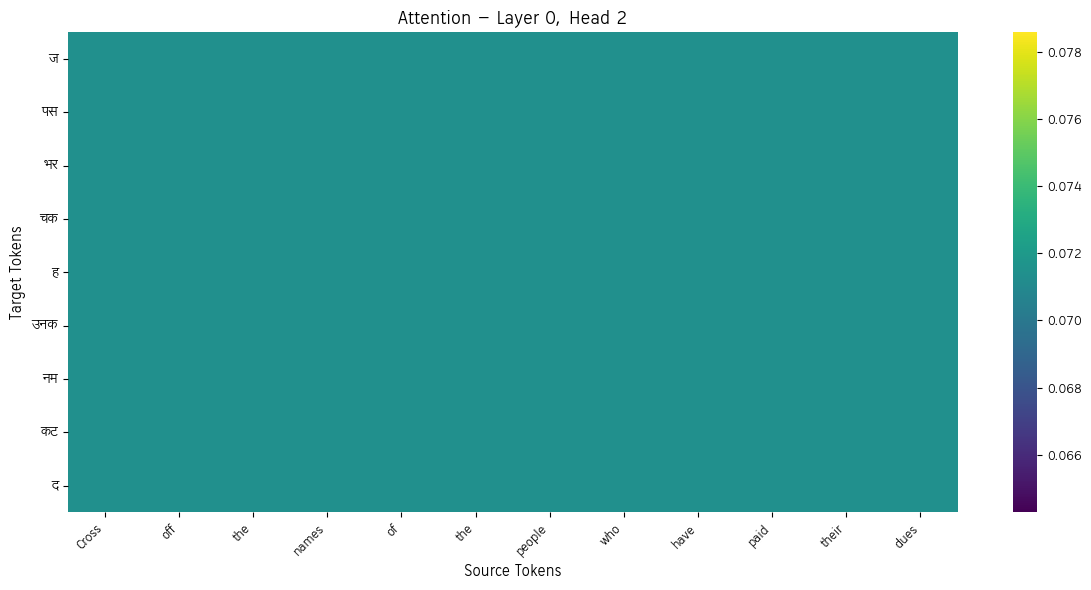

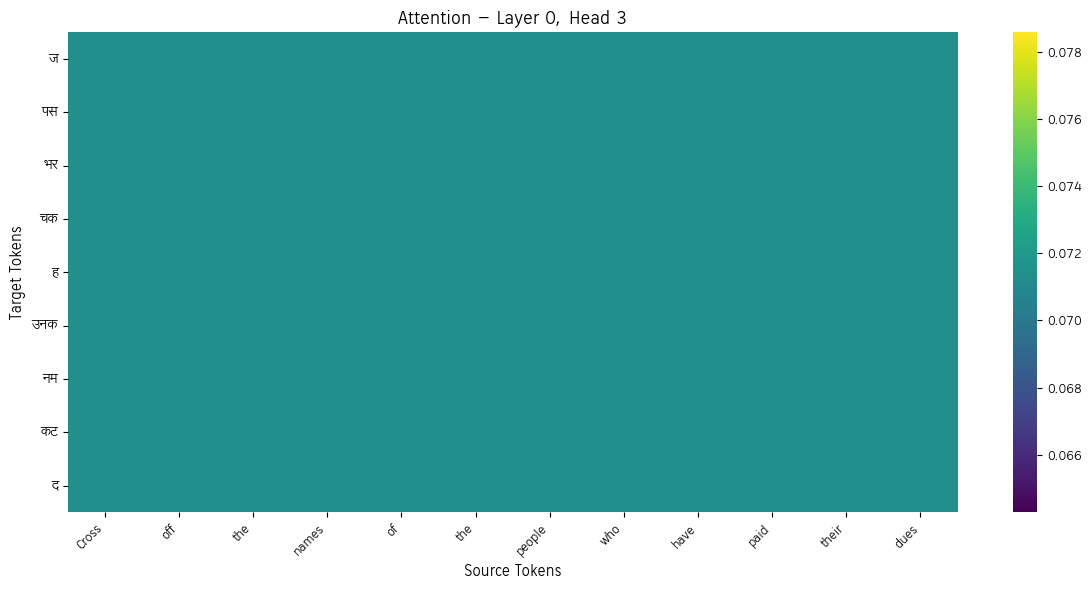

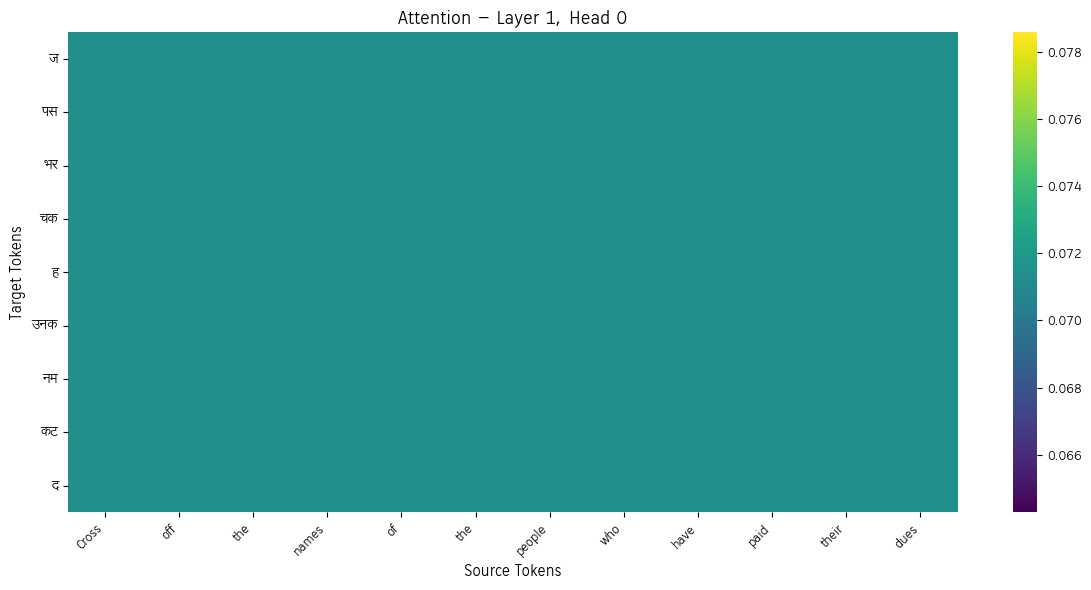

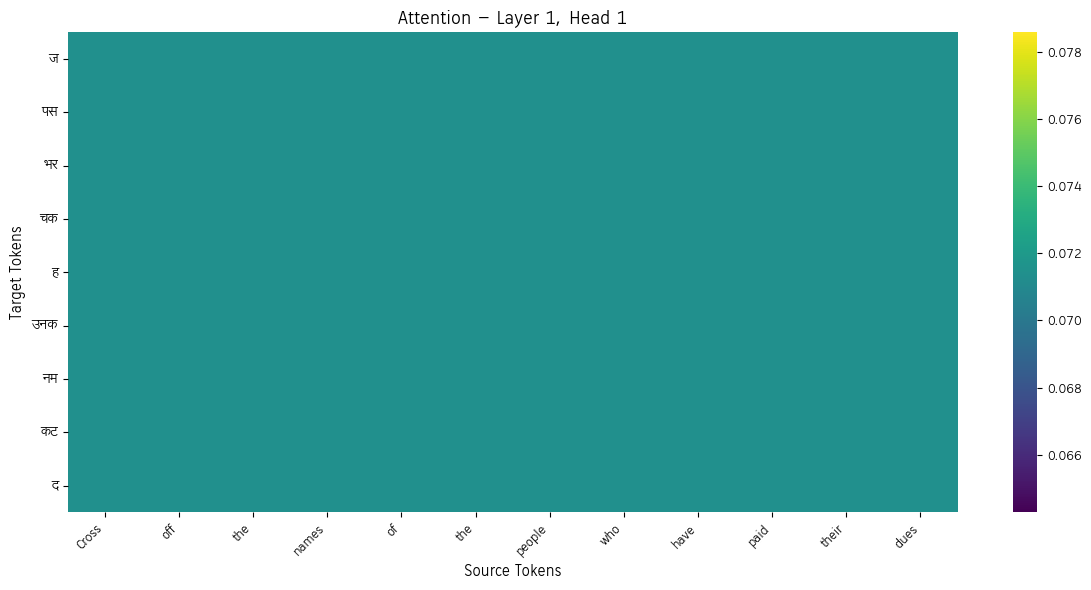

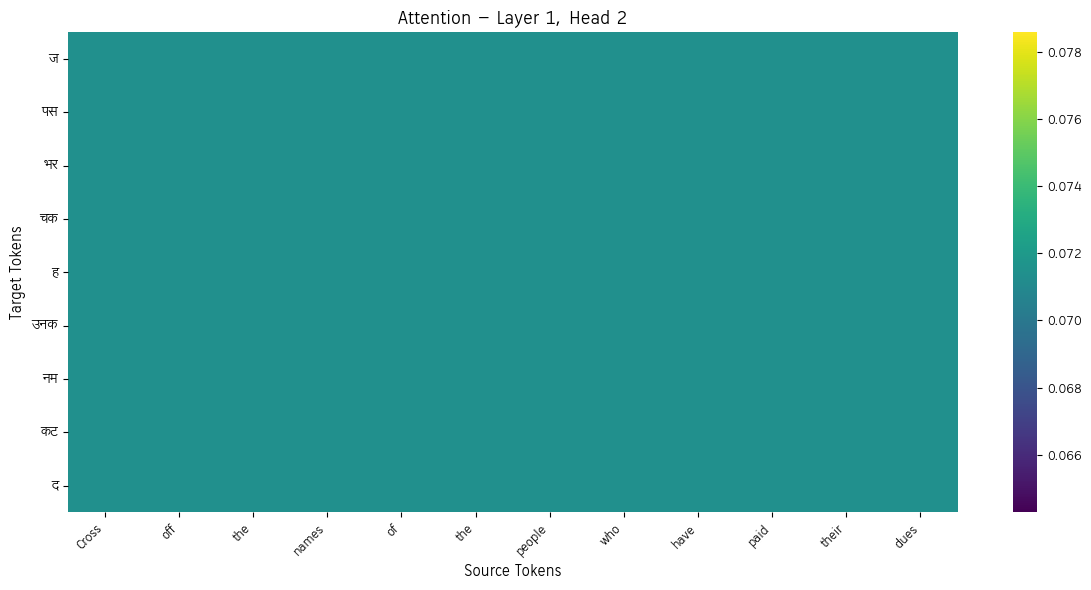

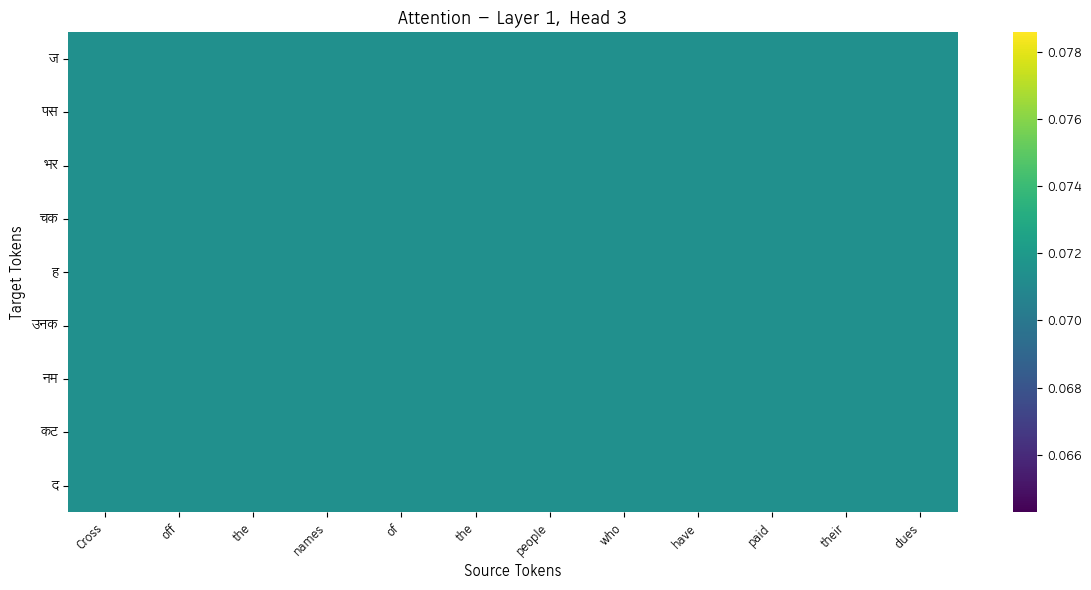

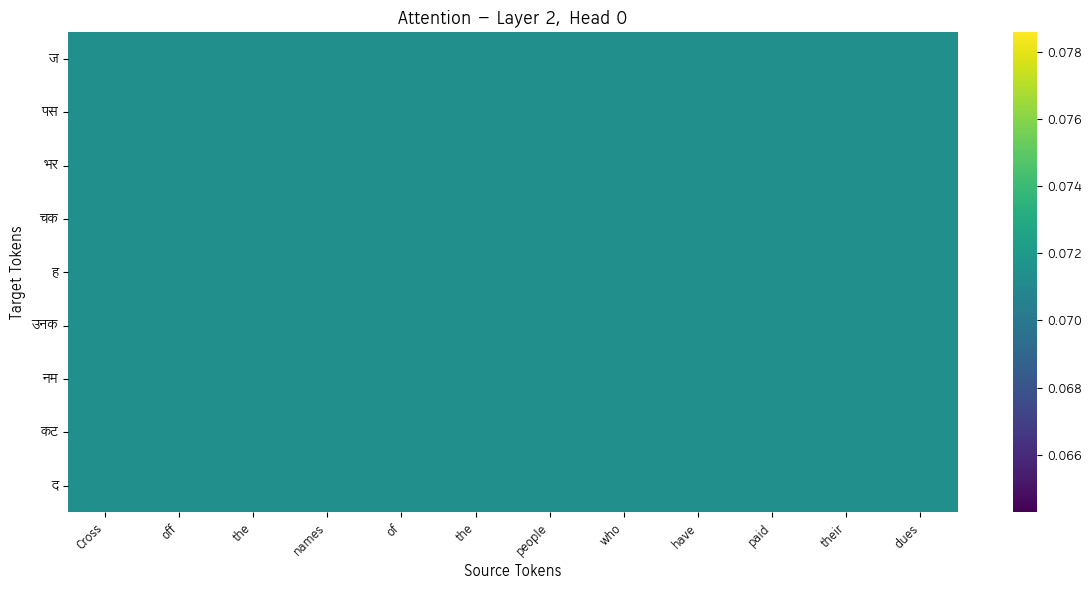

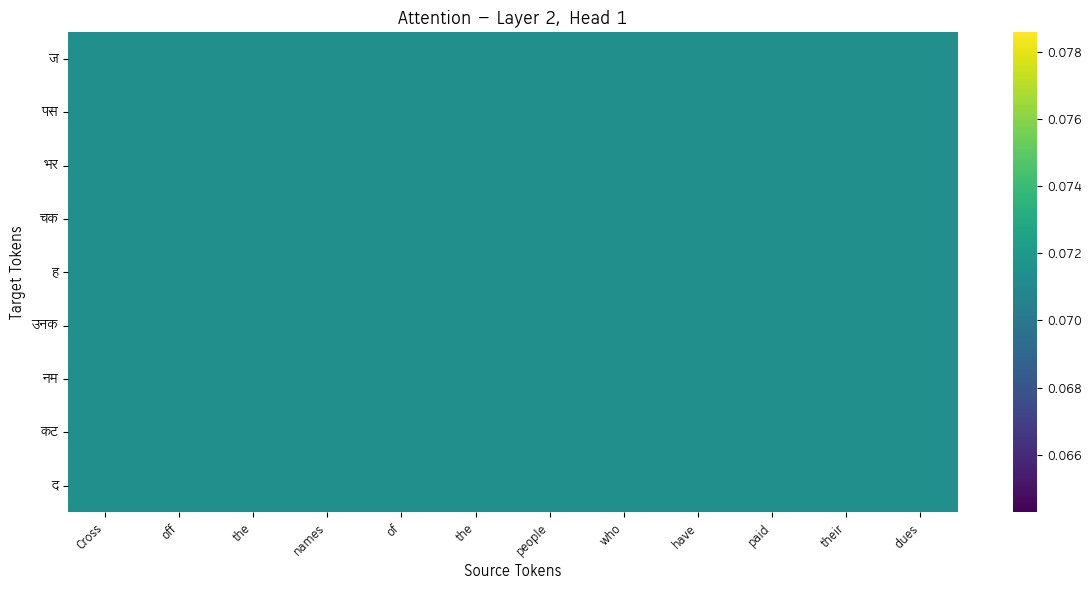

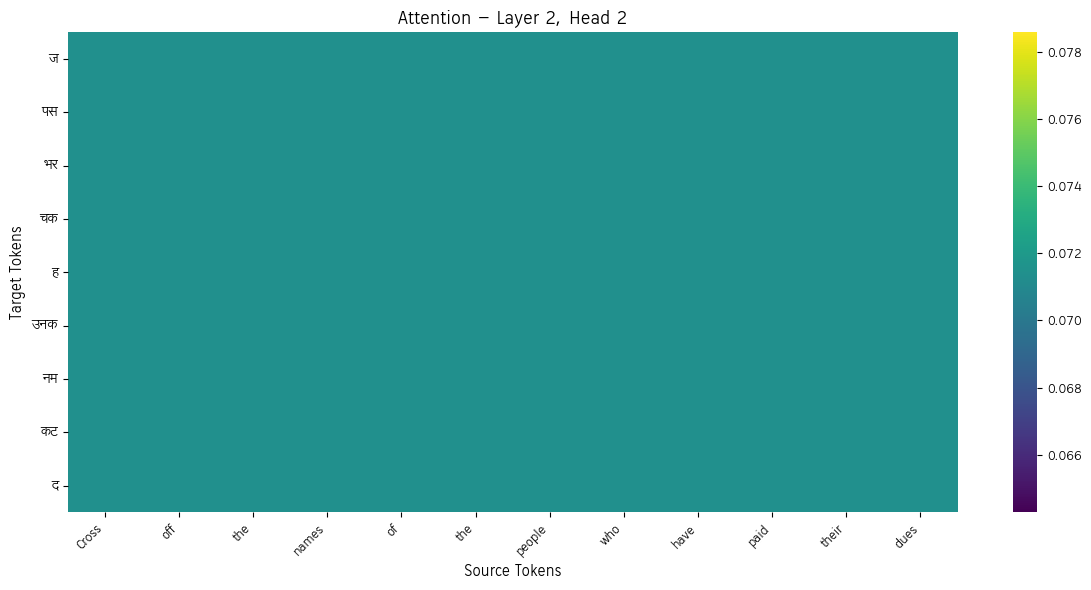

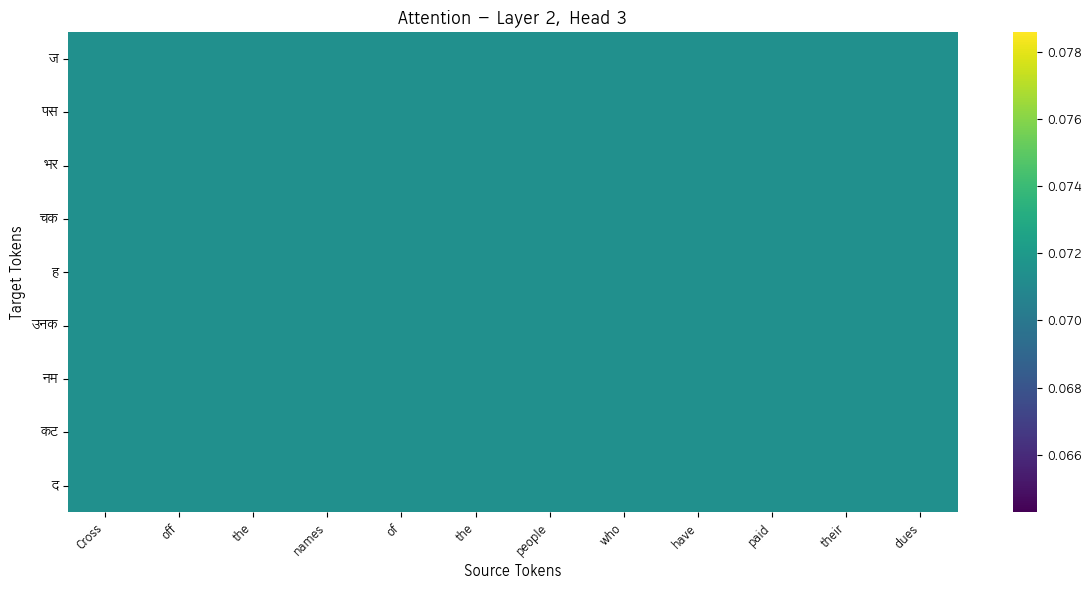

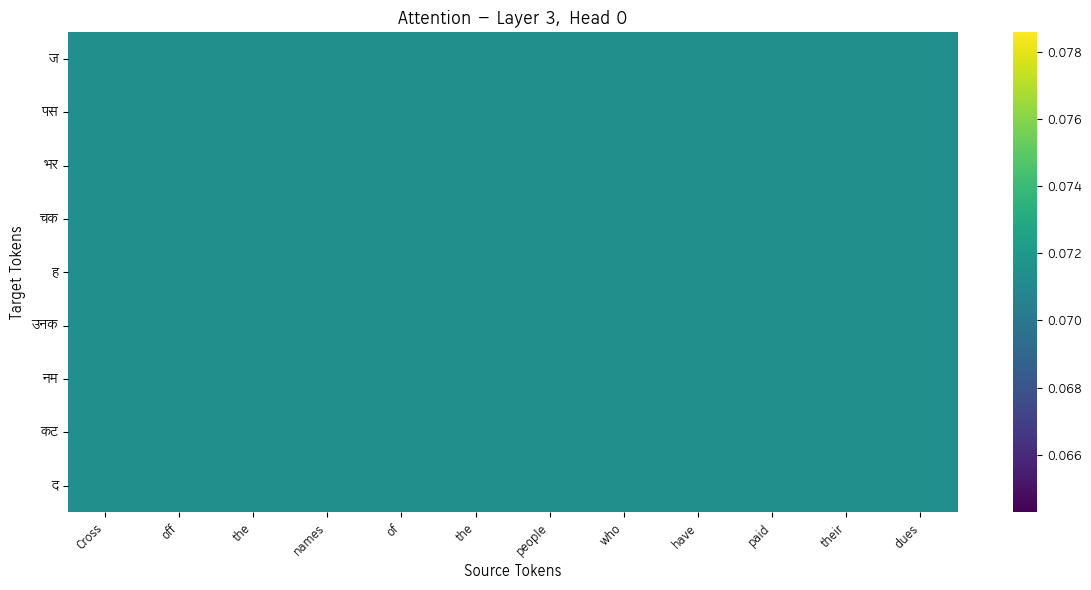

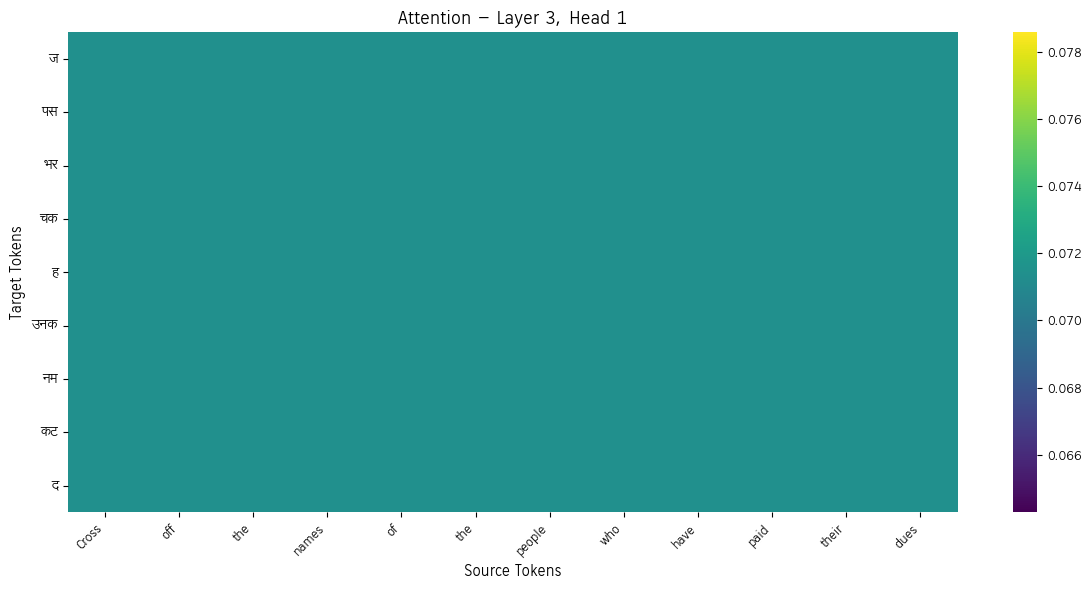

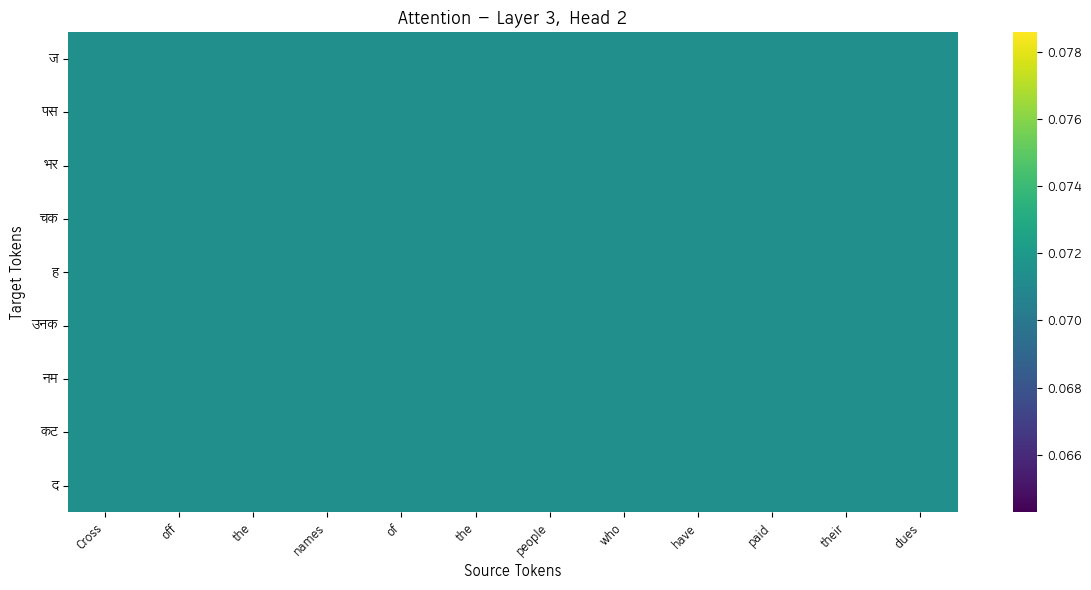

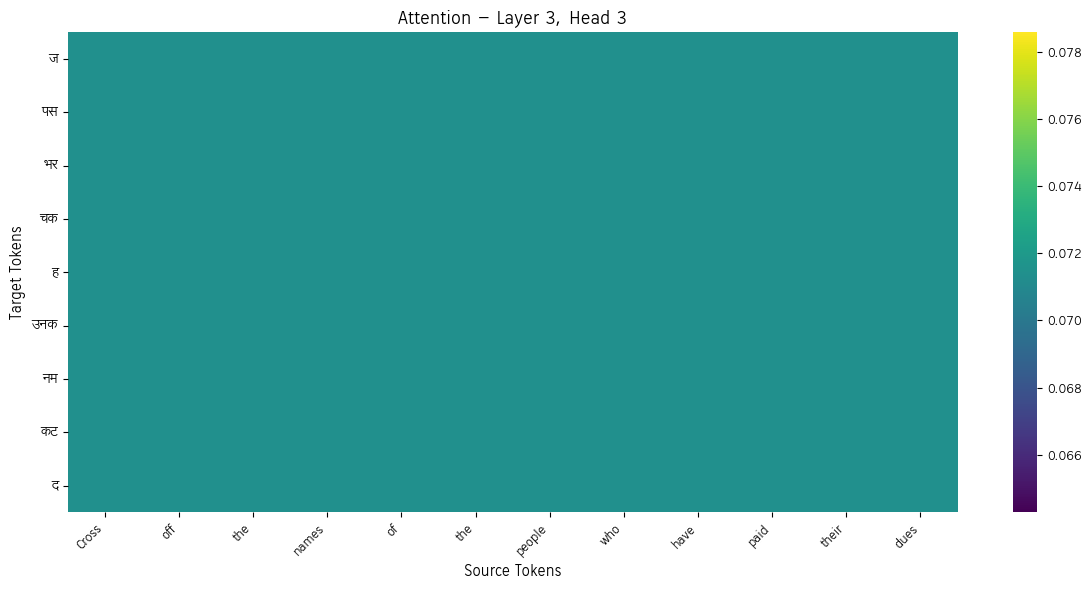

In [96]:
num_layers = attn_matrix.shape[0]
num_heads = attn_matrix.shape[1]

for l in range(num_layers):
    for h in range(num_heads):
        attn = attn_matrix[l][h]
        plot_attention(src_tokens, tgt_tokens, attn, layer=l, head=h)
